# 事前学習済みモデルmT5を用いたMultilingual NMTの例
Transformersモデルの一つ[101言語をカバーするT5モデルmT5](https://huggingface.co/docs/transformers/model_doc/mt5)を用いて、機械翻訳学習する流れを追いかけてみよう。

- 全体の流れ
    - 注意点
    - 環境構築
    - 関連モジュールの用意(import)
    - Tokenizer, Modelの用意(事前学習済みモデルの用意)
    - Transforersを使う際の Tips
    - トークナイザの動作確認
    - タスクに向けた専用トークンを追加
    - データセットの準備
    - ファインチューニング方針
        - データセット前処理
        - 前処理の動作確認
    - ファインチューニング部分
        - パラメータやモデル評価関数を準備
        - ファインチューニング
    - 学習中の損失推移
    - ファインチューニングしたモデルで翻訳してみる
- 参考
    - [Hugging Face公式ドキュメント](https://huggingface.co/docs/transformers/index)
    - [Transformers Notebooks](https://github.com/nlp-with-transformers/notebooks)
    - 今回の原本(original): [Multilingual NMT mt5](https://github.com/ejmejm/multilingual-nmt-mt5)
        - 英語ですが、動画解説あり。

## 注意点
- 専用の仮想環境構築を推奨する。
    - 機械学習ライブラリ[Hugging FaceのTransformers](https://huggingface.co/docs/transformers/installation)は、関連ライブラリのバージョン依存度が高いことから専用の仮想環境を構築することが推奨されている。自身の環境で試す際には venv で別途環境構築することを推奨する。
- CUDA環境での実行を推奨する。
    - 動作確認することを主眼としているため、系列長やエポック数を小さく設定している。それでもCPU環境では1エポックに1時間程度かかる。時間がない人はCUDA環境（Google Colab）での実行を推奨する。
- CPUで実行する際にはコードの一部を編集する必要がある。
    - コード中に ``.cuda()`` と付けている箇所は、CUDA環境が必須である。これを消せばCPU環境でも動作するようになる。

## 環境構築
仮想環境に入った状態で、下記のコメントアウトを外して実行しよう。

In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 関連モジュールの用意

In [ ]:
from datasets import load_dataset
#from google.colab import drive
#from IPython.display import display
#from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

## Tokenizer, Modelの準備
Transformersを利用するには大別して、(1)まっさらな状態から事前学習する、(2)事前学習済みモデルを用いてファインチューニングする、(3)ファインチューニング済みモデルを利用する、の3パターンが考えられる。

ここでは(2)を体験してみよう。最終的にやりたいことは機械翻訳（日英、英日）だ。このタスクのために今回は事前学習済みモデルとして[mT5](https://huggingface.co/docs/transformers/model_doc/mt5)を準備する。mT5は “Text-to-Text Transfer Transformer” (T5) と呼ばれる Google が開発したモデルをベースとし、多言語（101言語）で事前学習されたモデルだ。

- 参考
  - 公式で用意されている事前学習済みモデルは[MODELS](https://huggingface.co/docs/transformers/model_doc/albert)を参照しよう。
  - 一般開発者を含めたコミュニティで[公開されているモデル](https://huggingface.co/models)はここから検索しよう。

```{note}
事前学習済みモデルを利用する場合、事前学習時に用いたトークナイザ（≒分かち書き器）を利用する必要がある点に注意しよう。
```

In [ ]:
model_repo = 'google/mt5-small'   # 事前学習済みモデル
model_path = 'mt5_translation.pt' # ファインチューニングしたモデルを保存する際のファイル名
max_seq_len = 20 # トークン上限数。計算機リソースや学習時間に余裕があるなら増やしてみよう。

# トークナイザを準備
tokenizer = AutoTokenizer.from_pretrained(model_repo)

# 事前学習済みモデルを準備
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)

# 環境がCUDA対応してるなら、以下を実行することで高速実行可能。
# CPU実行したい場合にはコメントアウトしよう。
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


## Transformers を使う際の Tips
- 学習時に用いたトークナイザを用いる必要がある。
    - あるトークナイザXでは ``this`` を ``id = 1`` として割り振っているとしよう。このトークナイザXを使って学習したモデルにとっては ``1 == this``である。しかしファインチューニング時に別のトークナイザを使ってしまうと、idがずれたり、存在しない事もありえる。このような問題を起こさないためには事前学習とファインチューニングで用いるトークナイザを合わせる必要がある。
- モデルは、エンコードされた系列データでやり取りする。
    - モデルに対する入出力は「エンコードされた系列データ」である。分かち書きされたトークンに対しユニークなtoken_idを割り振り（これをエンコードと呼ぶ）、token_idを並べた系列データをモデルは受け取り、処理結果も同様のtoken_id系列データとして出力する。以下を実行して確認してみよう。
- 系列長は固定する必要がある。
    - 例えば固定長10で学習したモデルに対しては、それ未満の系列データを入力する場合には不足分を埋める必要がある。このためのトークンを padding token と呼ぶ。逆に10を超える系列データを入力する場合には、事前にサイズ10で打ち切る、もしくは文末トークンを考慮し9で打ち切る必要がある。

## トークナイザの動作確認

In [ ]:
# テキスト例
example_input_str = 'This is test.'

# tokenizer.encode() でエンコード。
token_ids = tokenizer.encode(
    example_input_str,          # 入力したいテキスト
    return_tensors='pt').cuda() # PyTorchのテンソル型を指定
print('token_ids = ', token_ids) 
print('-----------')

# 試しにモデルに入力して、その結果を受け取ってみる。
model_out = model.generate(token_ids)
print('model_out = ', model_out)
print('-----------')

# 分かりづらいので、出力結果を元の文字に戻す。
output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print('output_text = ', output_text)

token_ids =  tensor([[1494,  339, 2978,  260,    1]], device='cuda:0')
-----------
model_out =  tensor([[     0, 250099,      1]], device='cuda:0')
-----------
output_text =  <pad> <extra_id_0></s>


In [ ]:
# token_ids をもとに戻してみる。
# id=1 が </s> になっている。これは文末を表す特殊トークン。

tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens([1494,  339, 2978,  260,    1]))

'This is test.</s>'

In [ ]:
# トークン一覧を確認
# <pad>: padding用のトークン。トークン長を揃えるためのもの。
# </s>: 文末トークン。
# <unk>: unknownトークン。未知語は全てこれになる。

print(len(tokenizer.vocab))
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

250100


[('<pad>', 0),
 ('</s>', 1),
 ('<unk>', 2),
 ('<0x00>', 3),
 ('<0x01>', 4),
 ('<0x02>', 5),
 ('<0x03>', 6),
 ('<0x04>', 7),
 ('<0x05>', 8),
 ('<0x06>', 9),
 ('<0x07>', 10),
 ('<0x08>', 11),
 ('<0x09>', 12),
 ('<0x0A>', 13),
 ('<0x0B>', 14),
 ('<0x0C>', 15),
 ('<0x0D>', 16),
 ('<0x0E>', 17),
 ('<0x0F>', 18),
 ('<0x10>', 19),
 ('<0x11>', 20),
 ('<0x12>', 21),
 ('<0x13>', 22),
 ('<0x14>', 23),
 ('<0x15>', 24),
 ('<0x16>', 25),
 ('<0x17>', 26),
 ('<0x18>', 27),
 ('<0x19>', 28),
 ('<0x1A>', 29),
 ('<0x1B>', 30),
 ('<0x1C>', 31),
 ('<0x1D>', 32),
 ('<0x1E>', 33),
 ('<0x1F>', 34),
 ('<0x20>', 35),
 ('<0x21>', 36),
 ('<0x22>', 37),
 ('<0x23>', 38),
 ('<0x24>', 39),
 ('<0x25>', 40),
 ('<0x26>', 41),
 ('<0x27>', 42),
 ('<0x28>', 43),
 ('<0x29>', 44),
 ('<0x2A>', 45),
 ('<0x2B>', 46),
 ('<0x2C>', 47),
 ('<0x2D>', 48),
 ('<0x2E>', 49),
 ('<0x2F>', 50),
 ('<0x30>', 51),
 ('<0x31>', 52),
 ('<0x32>', 53),
 ('<0x33>', 54),
 ('<0x34>', 55),
 ('<0x35>', 56),
 ('<0x36>', 57),
 ('<0x37>', 58),
 ('<0x38>',

In [ ]:
# 短いトークン系列に対して padding する例。
# パラメータ padding でパディング方法を指定。'max_length'とすると、max_lengthで指定した長さになるまでパディングする。

example_input_str = 'This is test.'

token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len).cuda()
print('token_ids = ', token_ids)
print('len(token_ids[0]) = ', len(token_ids[0]))

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print('tokens = ', tokens)
print('len(tokens) =', len(tokens))

token_ids =  tensor([[1494,  339, 2978,  260,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0')
len(token_ids[0]) =  20
tokens =  ['▁This', '▁is', '▁test', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
len(tokens) = 20


In [ ]:
# 長いトークン系列に対して打ち切りする例。
# パラメータ trancation を Trueにする。

long_example_input_str = 'The mT5 model was presented in mT5: A massively multilingual pre-trained text-to-text transformer by Linting Xue, Noah Constant, Adam Roberts, Mihir Kale, Rami Al-Rfou, Aditya Siddhant, Aditya Barua, Colin Raffel.'
length = len(example_input_str.split())
print('length = ', length)

token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len).cuda()
print('token_ids = ', token_ids)
print('len(token_ids[0]) = ', len(token_ids[0]))

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print('tokens = ', tokens)
print('len(tokens) = ', len(tokens))

length =  3
token_ids =  tensor([[1494,  339, 2978,  260,    1,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0')
len(token_ids[0]) =  20
tokens =  ['▁This', '▁is', '▁test', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
len(tokens) =  20


## タスクに向けた専用トークンの追加
翻訳して欲しいということを伝えやすくするために専用のトークンを追加しよう。具体的には以下の通り。
- 日本語に翻訳して欲しい場合の書式: ``<jp> This is test.``
- 英語に翻訳してほしい場合の書式: ``<en> これはテストです。``

In [ ]:
# トークンの確認。
# <jp>, <en> はトークンが存在せず別トークン系列に分解されてしまうので、新しいトークンとして追加する。

example_input_str = '<jp> This is test.'

token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len).cuda()
print('token_ids = ', token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print('tokens = ', tokens)

token_ids =  tensor([[1042, 3889,  669, 1494,  339, 2978,  260,    1,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0')
tokens =  ['▁<', 'jp', '>', '▁This', '▁is', '▁test', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
example_input_str = '<en> これはテストです。'

token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len).cuda()
print('token_ids = ', token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print('tokens = ', tokens)

token_ids =  tensor([[  1042,    278,    669, 144591,  80822,   1252,    306,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0]], device='cuda:0')
tokens =  ['▁<', 'en', '>', '▁これは', 'テスト', 'です', '。', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
# 追加したいトークンを辞書型で用意。
LANG_TOKEN_MAPPING = {
    'ja': '<jp>',
    'en': '<en>'
}

print('元のボキャブラリ数 = ', len(tokenizer.vocab))

# tokenizer.add_special_tokens を使って追加。
# 追加したことをモデルにも伝える必要がある。
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict) # 専用トークン追加。

print('追加後のボキャブラリ数 = ', len(tokenizer.vocab))

model.resize_token_embeddings(len(tokenizer))     # モデルのembeddingを調整。

元のボキャブラリ数 =  250100
追加後のボキャブラリ数 =  250102


Embedding(250102, 512)

In [ ]:
# トークン追加後の動作確認。
# <ja> が一つのトークンとして処理されていることを確認。

example_input_str = '<jp> This is test.'

token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len).cuda()
print('token_ids = ', token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print('tokens = ', tokens)

token_ids =  tensor([[250100,   1494,    339,   2978,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0]], device='cuda:0')
tokens =  ['<jp>', '▁This', '▁is', '▁test', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## データセットの準備
ファインチューニングするためのデータセットを用意しよう。今回は13言語での対訳がある[alt](https://huggingface.co/datasets/alt)を使う。

### データセット外観
train, testが別途用意されており、それぞれ辞書型で保存されている。
- ``dataset['url']``: ソースURL
- ``dataset['translation']``: 対訳テキスト
  - ``dataset['translation']['ja']``: 日本語テキスト
  - ``dataset['translation']['en']``: 英語テキスト

In [ ]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

train_dataset = dataset['train']
test_dataset = dataset['test']

No config specified, defaulting to: alt/alt-parallel
Reusing dataset alt (/root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# 中身を確認してみよう。

train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。',
  'khm': 'អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃពីធីប្រកួតពានរង្វា

In [ ]:
print("train_dataset[0]['translation']['ja'] = ", train_dataset[0]['translation']['ja'])
print("train_dataset[0]['translation']['en'] = ", train_dataset[0]['translation']['en'])

train_dataset[0]['translation']['ja'] =  フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。
train_dataset[0]['translation']['en'] =  Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.


## ファインチューニング方針
- mT5への入出力データを対訳で用意する。
- やりたい翻訳は日英または英日のみだが、ファインチューニングでは言語を問わず対訳学習させる。
- 元の対訳文にはテキストのみが書かれているため、データセットとして利用する際には専用トークン ``<ja>, <en>`` を追加する。

### データセット前処理

In [ ]:
# モデルへの入力分をエンコードする関数。
# テキスト本文(text)に専用トークン(target_lang)を追加し、tokenizerでエンコード。
# 戻り値は token_id 系列。
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len).cuda()

  return input_ids[0]

# 対訳テキスト本文(text)をエンコード。ここでは専用トークンを追加しない。
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len).cuda()
  
  return token_ids[0]

# 上で用意した関数を使って、
# 翻訳対象テキスト(input_text)と翻訳後テキスト(target_text)の系列データを用意する。
# 実行する度に dataset['translation'] からランダムに2言語を選び、処理する。
def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

# format_translation_dataを使ってバッチデータを作成。
def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()   # CPU実行したいなら、.cuda()を外そう。
  batch_target_ids = torch.cat(targets).cuda()
  #batch_input_ids = torch.cat(inputs)         # CPU実行の例。
  #batch_target_ids = torch.cat(targets)

  return batch_input_ids, batch_target_ids

# transform_batchを効率よく作成するために yield で返す。
def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

### 前処理の動作確認
``train_dataset[0]`` を指定しているが、その中のどの言語を指定するかはランダム選択しているため、実行する都度結果が変わる。

In [ ]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed/cache-09ad8735b58de120.arrow


<jp> ▁Italy ▁have ▁de feat ed ▁Portugal ▁3 1-5 ▁in ▁Pool ▁C ▁of ▁the ▁2007 ▁ Rugby ▁World ▁Cup ▁at ▁Parc ▁des ▁Princes , ▁Paris , ▁France . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ フランス の パリ 、 パル ク ・ デ ・ プラン ス で 行われた 2007 年 ラグビー ワールド カップ の プール C で 、 イタリア は 31 対 5 で ポル ト ガル を下 した 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

## ファインチューニング部分

### パラメータやモデル評価関数を準備

In [ ]:
# Constants
n_epochs = 5    # エポック数
batch_size = 16 # バッチサイズ
print_freq = 50 # 途中経過を出力するタイミング(50バッチ毎に出力)
checkpoint_freq = 1000 # モデルを保存するタイミング(1000バッチ毎に上書き保存)
lr = 5e-4       # 学習率
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01) # 学習率の減衰スケジューラ。徐々に減らしていく。

# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

# 損失履歴を保存するリスト
losses = []

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# モデルを評価する関数。
# test_dataset を受け取り、平均損失を計算。
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

### ファインチューニング

In [ ]:
!date

Thu Jun 23 01:54:04 UTC 2022


In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 12.114 | lr: 0.00044642857142857147
Epoch: 1 | Step: 100 | Avg. loss: 5.509 | lr: 0.0004960707269155207
Epoch: 1 | Step: 150 | Avg. loss: 4.604 | lr: 0.0004916056438649759
Epoch: 1 | Step: 200 | Avg. loss: 4.273 | lr: 0.00048714056081443114
Epoch: 1 | Step: 250 | Avg. loss: 3.990 | lr: 0.0004826754777638864
Epoch: 1 | Step: 300 | Avg. loss: 3.813 | lr: 0.0004782103947133417
Epoch: 1 | Step: 350 | Avg. loss: 3.695 | lr: 0.00047374531166279694
Epoch: 1 | Step: 400 | Avg. loss: 3.614 | lr: 0.0004692802286122522
Epoch: 1 | Step: 450 | Avg. loss: 3.558 | lr: 0.0004648151455617075
Epoch: 1 | Step: 500 | Avg. loss: 3.488 | lr: 0.00046035006251116275
Epoch: 1 | Step: 550 | Avg. loss: 3.353 | lr: 0.00045588497946061796
Epoch: 1 | Step: 600 | Avg. loss: 3.444 | lr: 0.00045141989641007323
Epoch: 1 | Step: 650 | Avg. loss: 3.339 | lr: 0.0004469548133595285
Epoch: 1 | Step: 700 | Avg. loss: 3.293 | lr: 0.00044248973030898376
Epoch: 1 | Step: 750 | Avg. loss: 3.236 |

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.793 | lr: 0.00039953563136274335
Epoch: 2 | Step: 100 | Avg. loss: 2.830 | lr: 0.0003950705483121986
Epoch: 2 | Step: 150 | Avg. loss: 2.841 | lr: 0.00039060546526165383
Epoch: 2 | Step: 200 | Avg. loss: 2.805 | lr: 0.00038614038221110916
Epoch: 2 | Step: 250 | Avg. loss: 2.833 | lr: 0.00038167529916056437
Epoch: 2 | Step: 300 | Avg. loss: 2.753 | lr: 0.00037721021611001964
Epoch: 2 | Step: 350 | Avg. loss: 2.841 | lr: 0.00037274513305947496
Epoch: 2 | Step: 400 | Avg. loss: 2.804 | lr: 0.0003682800500089302
Epoch: 2 | Step: 450 | Avg. loss: 2.737 | lr: 0.00036381496695838544
Epoch: 2 | Step: 500 | Avg. loss: 2.722 | lr: 0.00035934988390784066
Epoch: 2 | Step: 550 | Avg. loss: 2.758 | lr: 0.000354884800857296
Epoch: 2 | Step: 600 | Avg. loss: 2.777 | lr: 0.0003504197178067512
Epoch: 2 | Step: 650 | Avg. loss: 2.766 | lr: 0.00034595463475620646
Epoch: 2 | Step: 700 | Avg. loss: 2.671 | lr: 0.00034148955170566173
Epoch: 2 | Step: 750 | Avg. loss: 2.723 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 2.425 | lr: 0.0002985354527594213
Epoch: 3 | Step: 100 | Avg. loss: 2.475 | lr: 0.0002940703697088766
Epoch: 3 | Step: 150 | Avg. loss: 2.477 | lr: 0.00028960528665833185
Epoch: 3 | Step: 200 | Avg. loss: 2.508 | lr: 0.00028514020360778707
Epoch: 3 | Step: 250 | Avg. loss: 2.466 | lr: 0.0002806751205572424
Epoch: 3 | Step: 300 | Avg. loss: 2.468 | lr: 0.00027621003750669766
Epoch: 3 | Step: 350 | Avg. loss: 2.477 | lr: 0.00027174495445615287
Epoch: 3 | Step: 400 | Avg. loss: 2.448 | lr: 0.00026727987140560814
Epoch: 3 | Step: 450 | Avg. loss: 2.454 | lr: 0.0002628147883550634
Epoch: 3 | Step: 500 | Avg. loss: 2.456 | lr: 0.0002583497053045187
Epoch: 3 | Step: 550 | Avg. loss: 2.405 | lr: 0.0002538846222539739
Epoch: 3 | Step: 600 | Avg. loss: 2.508 | lr: 0.0002494195392034292
Epoch: 3 | Step: 650 | Avg. loss: 2.424 | lr: 0.0002449544561528844
Epoch: 3 | Step: 700 | Avg. loss: 2.450 | lr: 0.0002404893731023397
Epoch: 3 | Step: 750 | Avg. loss: 2.431 | lr

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 2.222 | lr: 0.0001975352741560993
Epoch: 4 | Step: 100 | Avg. loss: 2.216 | lr: 0.00019307019110555458
Epoch: 4 | Step: 150 | Avg. loss: 2.266 | lr: 0.00018860510805500982
Epoch: 4 | Step: 200 | Avg. loss: 2.276 | lr: 0.0001841400250044651
Epoch: 4 | Step: 250 | Avg. loss: 2.199 | lr: 0.00017967494195392033
Epoch: 4 | Step: 300 | Avg. loss: 2.262 | lr: 0.0001752098589033756
Epoch: 4 | Step: 350 | Avg. loss: 2.207 | lr: 0.00017074477585283086
Epoch: 4 | Step: 400 | Avg. loss: 2.209 | lr: 0.00016627969280228613
Epoch: 4 | Step: 450 | Avg. loss: 2.229 | lr: 0.0001618146097517414
Epoch: 4 | Step: 500 | Avg. loss: 2.220 | lr: 0.00015734952670119664
Epoch: 4 | Step: 550 | Avg. loss: 2.210 | lr: 0.0001528844436506519
Epoch: 4 | Step: 600 | Avg. loss: 2.267 | lr: 0.00014841936060010715
Epoch: 4 | Step: 650 | Avg. loss: 2.240 | lr: 0.00014395427754956242
Epoch: 4 | Step: 700 | Avg. loss: 2.178 | lr: 0.0001394891944990177
Epoch: 4 | Step: 750 | Avg. loss: 2.253 |

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 2.059 | lr: 9.653509555277729e-05
Epoch: 5 | Step: 100 | Avg. loss: 2.038 | lr: 9.207001250223254e-05
Epoch: 5 | Step: 150 | Avg. loss: 2.040 | lr: 8.76049294516878e-05
Epoch: 5 | Step: 200 | Avg. loss: 2.016 | lr: 8.313984640114307e-05
Epoch: 5 | Step: 250 | Avg. loss: 1.998 | lr: 7.867476335059832e-05
Epoch: 5 | Step: 300 | Avg. loss: 2.020 | lr: 7.420968030005358e-05
Epoch: 5 | Step: 350 | Avg. loss: 2.082 | lr: 6.974459724950884e-05
Epoch: 5 | Step: 400 | Avg. loss: 1.987 | lr: 6.527951419896411e-05
Epoch: 5 | Step: 450 | Avg. loss: 2.088 | lr: 6.0814431148419366e-05
Epoch: 5 | Step: 500 | Avg. loss: 2.027 | lr: 5.634934809787462e-05
Epoch: 5 | Step: 550 | Avg. loss: 2.057 | lr: 5.188426504732988e-05
Epoch: 5 | Step: 600 | Avg. loss: 1.990 | lr: 4.7419181996785136e-05
Epoch: 5 | Step: 650 | Avg. loss: 2.036 | lr: 4.2954098946240404e-05
Epoch: 5 | Step: 700 | Avg. loss: 1.997 | lr: 3.848901589569566e-05
Epoch: 5 | Step: 750 | Avg. loss: 2.068 | lr: 3

In [ ]:
!date

Thu Jun 23 02:18:53 UTC 2022


## 学習中の損失推移

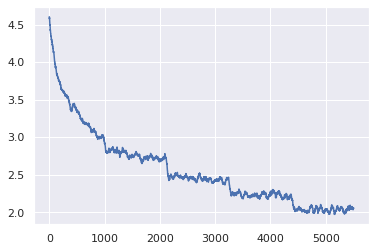

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

## ファインチューニングしたモデルで翻訳してみる

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0)

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

ニュージャージー州のRandwickRacecourseで8人の競輪のレース選手が
ニュージャージー州のRandwickRacecourseで8人の競輪のレース選手は
ニュージャージー州のRandwickRacecourseで8人の競輪の競輪の


## Google Colab でフォームを用いた実行例

In [ ]:
#@title Slick Blue Translate
input_text = 'This is test' #@param {type:"string"}
output_language = 'ja' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0)

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))


This is test  ->  これがテストの結果です。
